# Convolutional Neural Network From Scratch

In this notebook we will implement a convolutional and a pooling layer from scratch, as well as the forward propagation step of a CNN, in order to better understand their inner working. 

For this matter, we'll rely on both `numpy` and `pandas`, two of the most pervasive, relevant and foundational Python libraries for data science and machine learning.

## Preliminaries

Let's start by importing the libraries we will need.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

Let's now configure some default parameters:

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## Our Plan

Our plan is to implement the following model:

<img src="assets/model.png" style="width:800px;height:300px;">

In particular, we'll implement functions to create two of the most important building blocks of CNNs: **Convolutional layers**, and **Pooling layers**. 

Given that for each forward functions there's a backward equivalent, we will store some parameters in a cache to avoid unnecessary re-computation.

## CNNs: Harder than They Look

TensorFlow, Keras, fast.ai, PyTorch, Caffe, Deeplearning4j... These are some of the frameworks that make programming convolutional neural networks seem easy. However, CNNs remain one of the hardest concepts to understand in the field of deep learning. 

### Convolving

This is the main operation of a convolutional layer. In a nutshell, it transforms an input volume into an output volume with different size.

<img src="assets/conv_nn.png" style="width:350px;height:200px;">

### Padding

<img src="assets/PAD.png" style="width:600px;height:400px;">
<caption><center> Zero-Padding<br> Image (3 channels, RGB) with a padding of 2. </center></caption>

Padding consists of adding zeroes to the border of an image to allow convolution operations to happen near the edges of the picture.

This has the benefit of helping us keep information that appears at the border of an image, which, without padding, would be otherwise lost.

Also, we can convolve the volumes without necessarily shrinking the height and width of the volumes.

Let's implement a padding function:

In [3]:
def zero_pad(X, pad):
    """
    :param X: X is a tensor of dimensions (batch_size, height, width, number_of_channels)
    :param pad: Amount of padding to be applied to the horizontal and vertical dimensions of a volume.
    
    :return Zero-padded X tensor with shape (batch_size, height + 2 * pad, width + 2 * pad, number_of_channels)
    """
    
    # Here we apply 'constant' padding to the widht and height. The first and last [(0, 0)] tell np.pad we want to pad with zeroes
    # each batch and each channel of the volume. The default contant value for padding is zero, that's why we don't specify it
    # explicitly.
    X_pad = np.pad(X, [(0, 0)] + [(pad, pad) for _ in range(len(X.shape[1:-1]))] + [(0, 0)], 'constant')

Let's try it.

In [4]:
np.random.seed(1)

X = np.random.randn(4, 3, 3, 2)
X_pad = zero_pad(X, 2)

print(f'X shape: {X.shape}')
print(f'X_pad shape: {X_pad.shape}')

X shape: (4, 3, 3, 2)
X_pad shape: (4, 7, 7, 2)


Let's show both X and X_pad as images:

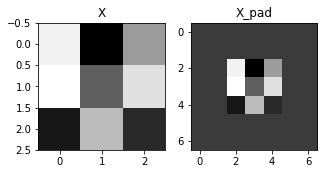

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title('X')
ax[0].imshow(X[0, :, :, 0])

ax[1].set_title('X_pad')
ax[1].imshow(X_pad[0, :, :, 0])

We can see that `X_pad` has a thicker black area surrounding the original `X` image, which makes sense because 0 represents full black in a grayscale image.

### Convolution Step

Let's now move to the main step: Convolving!

Just as a quick reminder, see the image below to recall how a convolution operation works:

<img src="assets/Convolution_schematic.gif" style="width:500px;height:300px;">
<caption><center> Convolution operation<br> with a filter of 2x2 and a stride of 1 (stride = amount you move the window each time you slide) </center></caption>

Here each value on the left corresponds to a single pixel value, and we are convolving them using a 3x3 filter. The operation, then, consists on multiplying the elements in the region of the image by the elements in the filter, in a element-wise fashion. Finally, we sum them all to produce a single entry in the resulting volume.

In [7]:
def convolution_step(previous_layer_slice, weights, bias):
    s = np.multiply(previous_layer_slice, weights)
    result = np.sum(s)
    result += bias[0, 0, 0]
    
    return Z

Let's try it:

In [9]:
np.random.seed(1)

previous_layer_slice = np.random.randn(4, 4, 3)  
weights = np.random.randn(4, 4, 3)  # This is the filter we will apply
bias = np.random.rand(1, 1, 1)

Z = convolution_step(previous_layer_slice, weights, bias)

print(f'Z = {Z}')

Z = -6.094205555853435


As we saw, the function we just implement applies a convolution operation over a single area/slace from the previous layer. Hence, if we actually want to produce a new volume, we must apply this function many tmes. In other words, we must implement a forward pass.

### CNNs - Forward Pass

We will implement the following process:
    
<center>
<video width="620" height="440" src="assets/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

We will apply a set of filters all over the input volume to produce the proper output.

NOTE: We won't worry about efficiency here. We'll rather focus on simplicity. This is why we will implement an iterative solution instead of a vectorized one.

In [12]:
def convolution_forward(previous_layer, filters, biases, hyper_parameters):
    
    # Extract previous layer dimensions
    (batch_size, previous_height, previous_width, previous_channels) = previous_layer.shape
    
    
    # Extract convolution filters dimensions
    (filter_size, filter_size, previous_channels, number_of_filters) = filters.shape
    
    # Extract relevant hyper parameters.
    stride = hyper_parameters['stride']
    pad = hyper_parameters['pad']
    
    # Compute the dimensions of the output:
    output_height = int((previous_height - filter_size + 2 * pad) / stride + 1)
    output_width = int((previous_width - filter_size + 2 * pad) / stride + 1)
    
    # Initialize output volume with zeroes
    output_volume = np.zeros((batch_size, output_height, output_width, number_of_filters))
    
    # Pad the previous layer
    previous_layer_padded = zero_pad(previous_layer, pad)
    
    for i in range(batch_size):
        padded_training_example = previous_layer_padded[i, :, :, :]
        
        for h in range(0, output_height):
            for w in range(0, output_width):
                for c in range(number_of_filters):
                
                    # Find the corners of the current slice
                    vertical_start = w
                    vertical_end = w + filter_size
                    horizontal_start = h
                    horizontal_end = h + filter_size
                    
                    # Use the corners to define the (3D) slice of padded_training_example
                    padded_slice = padded_training_example[vertical_start:vertical_end,
                                                           horizontal_start:horizontal_end]
                    
                    # Apply convolution:
                    weights = filters[:, :, :, c]
                    bias = biases[:, :, :, c]
                    
                    output_volume[i, h, w, c] = convolution_step(padded_slice, weights, bias)
                    
    # Sanity check to check the output dimensions are correct
    assert(output_volume.shape == (batch_size, output_height, output_width, number_of_filters))
    
    # Cache information
    cache = (previous_layer, filters, biases, hyper_parameters)
    
    return output_volume, cache

Let's try it.

In [13]:
np.random.seed(1)

previous_layer = np.random.randn(10, 4, 4, 3)
filters = np.random.randn(2, 2, 3, 8)
biases = np.random.randn(1, 1, 1, 8)

hyper_parameters = {
    'pad': 2,
    'stride': 2
}

output_volume, cache = convolution_forward(previous_layer, filters, biases, hyper_parameters)

print(f'output mean: {np.mean(output_volume)}')
print(f'output[3, 2, 1]: {output_volume[3, 2, 1]}')
print(f'cache[0][1][2][3]: {cache[0][1][2][3]}')

output mean: -0.0078019720931586075
output[3, 2, 1]: [ 0.49930938 -0.47299672  0.32697871  2.02563725  0.4256935   2.47682402
 -1.78597367  0.35094674]
cache[0][1][2][3]: [-0.20075807  0.18656139  0.41005165]


Notice the resulting volume hasn't been activated.

### Pooling Layers

Pooling layers are a great way to both summarize the information in a volume and reduce its dimensionality.

The method to do this follows a similar recipe than in the case of convolutions: We apply the operation over different slices of the input volume. However, we don't need filters. Instead, we always apply the same operaton (typically a `max` or `avg` operation).

Although these layers don't need to be trained, they require some hyper parameters, such as the window size

<table>
<td>
<img src="assets/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="assets/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

Let's implement a function to apply either Max Pooling or Average Pooling:

In [14]:
def pool_forward(previous_layer, hyper_parameters, mode='max'):
    assert mode in {'max', 'average'}, 'Mode must be either max or average.'
    
    # Retrieve input shape
    (batch_size, previous_height, previous_width, previous_channels) = previous_layer.shape
    
    # Retrieve relevant hyper parameters
    window_size = hyper_parameters['window_size']
    stride = hyper_parameters['stride']
    
    # Define output shape
    output_height = int(1 + (previous_height - window_size) / stride)
    output_width = int(1 + (previous_width - window_size) / stride)
    output_channels = previous_channels
    
    # Initialize output
    output_volume = np.zeros((batch_size, output_height, output_width, output_channels))
    
    for i in range(batch_size):
        for h in range(output_height):
            for w in range(output_width):
                for c in range(output_channels):
                    
                    # Find the corners of the current slice
                    vertical_start = w
                    vertical_end = w + window_size
                    horizontal_start = h
                    horizontal_end = h + window_size
                    
                    # Use the corners to define the current slice on the ith training example
                    previous_slice = previous_layer[vertical_start:vertical_end,
                                                    horizontal_start:horizontal_end,
                                                    c]
                    
                    if mode == 'max':
                        output_volume[i, h, w, c] = np.max(previous_slice)
                    else:
                        output_volume[i, h, w, c] = np.mean(previous_slice)
                        
    # Sanity check
    assert output_volume.shape == (batch_size, output_height, output_width, output_channels)
    
    cache = (previous_layer, hyper_parameters)
    
    return output_volume, cache

Test run:


In [17]:
np.random.seed(1)
previous_layer = np.random.randn(2, 4, 4, 3)
hyper_parameters = {
    'stride': 2,
    'window_size': 3
}

for mode in ['max', 'average']:
    
    output_volume, cache = pool_forward(previous_layer, hyper_parameters, mode)
    print(f'Mode: {mode}')
    print(f'Output: \n\t{output_volume}\n')

Mode: max
Output: 
	[[[[1.62434536 0.86540763 2.18557541]]]


 [[[1.62434536 0.86540763 2.18557541]]]]

Mode: average
Output: 
	[[[[ 0.24481813 -0.47568152  0.3263877 ]]]


 [[[ 0.24481813 -0.47568152  0.3263877 ]]]]



We are done! We implemented two of the most important building blocks of CNNs. Quite a handful of code, right? This is what deep learning frameworks like TensorFlow or Keras do under the hood.